In [1]:
%reload_ext autoreload
%autoreload 2

import cv2

import os
import sys
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *

from collections import defaultdict

from matplotlib.path import Path
%matplotlib inline

from enum import Enum

class ProposalType(Enum):
    GLOBAL = 'global'
    LOCAL = 'local'
    FREEFORM = 'freeform'
    ALGORITHM = 'algorithm'
    
class PolygonType(Enum):
    CLOSED = 'closed'
    OPEN = 'open'
    TEXTURE = 'textured'
    TEXTURE_WITH_CONTOUR = 'texture with contour'
    DIRECTION = 'directionality'

from FeatureExtractor import *

In [9]:
first, last = section_range_lookup['MD589']
dms = dict([(sc, DataManager(stack='MD589', section=sc, segm_params_id='tSLIC200', load_mask=False)) 
            for sc in range(first, last)])

In [56]:
vertices_Gr = np.array(props[1]['vertices'])

In [10]:
landmark_images = {}
adjusted_vertices = {}

sec = 120

print sec

usr, ts, suffix, props =  dms[sec].load_proposal_review_result('yuncong', 'latest', 'consolidated')

vertices = np.array(props[0]['vertices'])

xmin, ymin  = np.min(vertices, axis=0).astype(np.int) - 300
xmax, ymax  = np.max(vertices, axis=0).astype(np.int) + 300

dms[sec]._load_image(['rgb'])
viz = dms[sec].image_rgb[ymin:ymax+1, xmin:xmax+1].copy()
landmark_images[sec] = viz
del dms[sec].image_rgb

120


/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/PIL/Image.py:2261: DecompressionBombWarning: Image size (294524928 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


In [13]:

adjusted_vertices[sec] = vertices - (xmin, ymin)

patch_size = 224
half_size = patch_size/2
stride = 56

patches_allSections = {}
patch_locations_allSections = {}
patches = []
patch_locations = []

h, w = landmark_images[sec].shape[:2]
ys, xs = np.meshgrid(np.arange(half_size, h-half_size, stride), np.arange(half_size, w-half_size, stride))
polygon_path = Path(adjusted_vertices[sec])
for x, y in np.c_[xs.flat, ys.flat]:
#     if np.all(polygon_path.contains_points([(x-half_size, y-half_size),(x+half_size, y-half_size),
#                                             (x+half_size, y+half_size),(x-half_size, y+half_size)])):
    patch = landmark_images[sec][y-half_size:y+half_size, x-half_size:x+half_size].copy()
    patches.append(patch)
    patch_locations.append((x,y))
        
patches_allSections[sec] = patches
patch_locations_allSections[sec] = patch_locations

In [14]:
all_patches = [p for sec, patches in patches_allSections.iteritems() for p in patches]
print len(all_patches), 'patches'

1280 patches


In [15]:
all_patches_arr = np.array([img_as_ubyte(p) for p in all_patches], np.uint8)

In [ ]:
np.save('test.npy', all_patches_arr)

In [3]:
features = np.load('test_features.npy')

In [ ]:
# os.environ['MODEL_DIR'] = '/oasis/projects/nsf/csd395/jiaxuzhu/model/'
# model_dir = os.environ['MODEL_DIR']+'/vgg16'

# fe = FeatureExtractor(model_dir, batch_size=16, ctx='cpu')

# images = all_patches_arr.transpose(0, 3, 1, 2)
# print images.shape

# features = fe.extract(images)
# print features.shape
# # np.save(os.path.join(data_dir, '%s_features.npy' % name), features)

In [4]:
label1 = '12N'
label2 = 'Gr'

In [5]:
coef = np.load('%s_%s_linear_svm_coef.npy' % (label1, label2))
intercept = np.load('%s_%s_linear_svm_intercept.npy' % (label1, label2))
selected_feature_indices = np.load('%s_%s_linear_svm_selectedFeatureIndices.npy' % (label1, label2))

In [6]:
scores = np.dot(features[:, selected_feature_indices], np.squeeze(coef)) + intercept
Y = np.sign(scores)

In [67]:
viz2 = img_as_ubyte(viz.copy())

In [68]:
cv2.polylines(viz2, [np.int32(adjusted_vertices[sec])], True, (255,0,255), 5)
cv2.polylines(viz2, [np.int32( vertices_Gr - (xmin, ymin))], True, (0,255,255), 5)

In [69]:
thresh = 1.1

for (x, y), sc in zip(patch_locations, scores):
    if sc > thresh:
        c = (0,255,0)
    else:
        c = (255,0,0)
#     cv2.rectangle(viz2, (x-half_size, y-half_size), (x+half_size, y+half_size), c, 5)
    cv2.circle(viz2, (x,y), 10, c, 5)

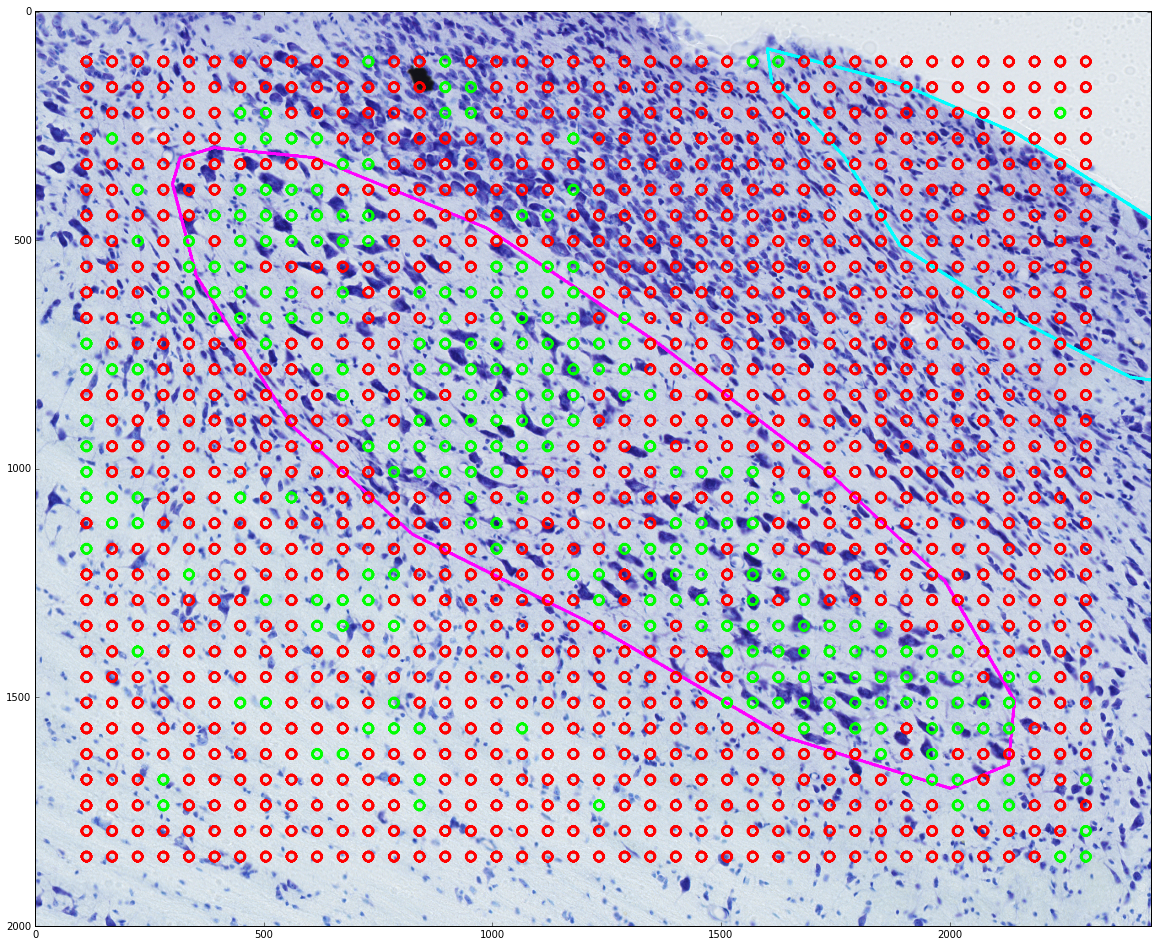

In [70]:
plt.figure(figsize=(20,20));
plt.imshow(viz2);

In [55]:
plt.imsave('labelmap_score%.2f.jpg'%thresh, viz2)

In [ ]:
display(viz2)